# Preprocessing NHTS and Images


In [12]:
!pip install opencv-python

In [13]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import pickle
import copy
from sklearn.preprocessing import normalize
from sklearn.preprocessing import OneHotEncoder
import skimage.io as io
import sys
import util

import random

In [14]:
# read two csv files and merge them.
df_nhts = pd.read_csv("data_initial/raw/data_input_V1.csv")
df_loc = pd.read_csv("data_initial/raw/hhct.csv")

df_loc.drop('HHSTFIPS', axis = 1, inplace = True)

# augment HHCT to df_nhts
df = pd.merge(df_nhts, df_loc, on = 'HOUSEID')

In [15]:
# Create census tract ID by combining columns.
# HHSTFIPS: 2 digits; HHCNTYFP: 3 digits; HHCT: 6 digits. Add zeros in front.
df['HHSTFIPS'] = df['HHSTFIPS'].astype(np.str)
df['HHCNTYFP'] = df['HHCNTYFP'].astype(np.str)
df['HHCT'] = df['HHCT'].astype(np.str)
# HHSTFIPS
df['HHSTFIPS'].loc[df['HHSTFIPS'].str.len() == 1, ] = '0' + df['HHSTFIPS'].loc[df['HHSTFIPS'].str.len() == 1, ]
# HHCNTYFP
for i in range(2): # 2 = 3-1
    augmented_zero_str = '0' * (i+1)
    df['HHCNTYFP'].loc[df['HHCNTYFP'].str.len() == 2-i, ] = augmented_zero_str + df['HHCNTYFP'].loc[df['HHCNTYFP'].str.len() == 2-i, ]
# HHCT
for i in range(5): # 5 = 6-1
    augmented_zero_str = '0' * (i+1)
    df['HHCT'].loc[df['HHCT'].str.len() == 5-i, ] = augmented_zero_str + df['HHCT'].loc[df['HHCT'].str.len() == 5-i, ]
# Create the census tract identifier
df['CENSUS_ID'] = df['HHSTFIPS'] + df['HHCNTYFP'] + df['HHCT']

## Edit dependent variables (travel behavior variables)

In [16]:
# TRPTRANS
# 0 other
# 1 walk and bike
# 2 car, suv, van, and truck
# 3 public trans
df["TRPTRANS"].values[(df["TRPTRANS"] == 1) | (df["TRPTRANS"] == 2)] = 1
df["TRPTRANS"].values[(df["TRPTRANS"] == 3) | (df["TRPTRANS"] == 4) | (df["TRPTRANS"] == 5) | (df["TRPTRANS"] == 6)] = 2
df["TRPTRANS"].values[(df["TRPTRANS"] == 10) | (df["TRPTRANS"] == 11) | (df["TRPTRANS"] == 14) | (df["TRPTRANS"] == 15) | (df["TRPTRANS"] == 16) | (df["TRPTRANS"] == 12)] = 3
df["TRPTRANS"].values[(df["TRPTRANS"] == 7) | (df["TRPTRANS"] == 8) | (df["TRPTRANS"] == 9)
                      | (df["TRPTRANS"] == 13) | (df["TRPTRANS"] == 17)| (df["TRPTRANS"] == 18) | (df["TRPTRANS"] == 19) 
                      | (df["TRPTRANS"] == 20) | (df["TRPTRANS"] == 97)] = 0

# TRIPPURP
# {'HBO', 'HBSHOP', 'HBSOCREC', 'HBW', 'NHB'}
# {0,1,2,3,4}
df["TRIPPURP"].values[df["TRIPPURP"] == "HBO"] = 0
df["TRIPPURP"].values[df["TRIPPURP"] == "HBSHOP"] = 1
df["TRIPPURP"].values[df["TRIPPURP"] == "HBSOCREC"] = 2
df["TRIPPURP"].values[df["TRIPPURP"] == "HBW"] = 3
df["TRIPPURP"].values[df["TRIPPURP"] == "NHB"] = 4
df["TRIPPURP"].values[df["TRIPPURP"] == "-9"] = -9

In [17]:
# print
print(np.unique(df.TRPTRANS, return_counts=True))
print(list(np.unique(df.TRIPPURP, return_counts=True)))

(array([0, 1, 2, 3]), array([ 13624,  59793, 695869,  12545]))
[array([-9, 0, 1, 2, 3, 4], dtype=object), array([    20, 133735, 174099,  88969, 111571, 273437])]


In [18]:
# drop negative TRIPPURP (20 observations)
df = df.loc[df.TRIPPURP >= 0, :]
# drop negative trip miles. 
df = df.loc[df.TRPMILES >= 0, :]
# drop negative trip durations.
df = df.loc[df.TRVLCMIN >= 0, :]

In [19]:
# Create dummies for the dependent variables. 
# This automatically drop the two initial discrete variables from df.
df = pd.get_dummies(data=df, columns=["TRPTRANS","TRIPPURP"])

In [20]:
# drop the old variables
print(df.shape)
df.head()

(781811, 268)


,CDIVMSAR,CENSUS_D,CENSUS_R,DRIVER,DRVRCNT,ENDTIME,EDUC,GASPRICE,HBHTNRNT,HBHUR,...,CENSUS_ID,TRPTRANS_0,TRPTRANS_1,TRPTRANS_2,TRPTRANS_3,TRIPPURP_0,TRIPPURP_1,TRIPPURP_2,TRIPPURP_3,TRIPPURP_4
0,53,5,3,1,3,1015,3,228.4,20,T,...,37191001301,0,0,1,0,1,0,0,0,0
1,53,5,3,1,3,1530,3,228.4,20,T,...,37191001301,0,0,1,0,1,0,0,0,0
2,53,5,3,1,3,900,3,228.4,20,T,...,37191001301,0,0,1,0,0,0,0,1,0
3,53,5,3,1,3,2030,3,228.4,20,T,...,37191001301,0,0,1,0,0,0,0,1,0
4,53,5,3,1,3,900,2,228.4,20,T,...,37191001301,0,0,1,0,1,0,0,0,0


In [23]:
# Use HOUSEID and PERSONID to check redundancy.
print("Number of CENSUS_ID is: ", len(np.unique(df.CENSUS_ID)))
print("Number of HHs is: ", len(np.unique(df.HOUSEID)))
print("Maximum persons in each HH: ", len(np.unique(df.PERSONID)))

Number of CENSUS_ID is:  32681
Number of HHs is:  110565
Maximum persons in each HH:  10


## Clean independent variables

In [24]:
# continuous variables
# income
inc_dic = {1:10.0, 2:12.5, 3:20.0, 4:30.0, 5:42.5, 
          6:62.5, 7:87.5, 8:112.5, 9:137.5, 10:175.0, 11:200.0}
df.HHFAMINC.replace(to_replace = inc_dic, inplace = True)

# renter occupied housing ratio.
df = df.loc[df.HBHTNRNT >= 0, :]
rent_dic = {0:0.02, 5:0.1, 20:0.2, 30:0.3, 40:0.4, 50:0.5, 60:0.6, 70:0.7, 80:0.8, 90:0.9, 95:0.975}
df.HBHTNRNT.replace(to_replace=rent_dic, inplace = True)

# pop density
df = df.loc[df.HBPPOPDN >= 0, :]

# residential density
df = df.loc[df.HBRESDN >= 0, :]

In [25]:
# discrete variables
# educ
# 0: no reported; 1: high school and lower; 2: college and higher
educ_dic_1 = {-8:8, -7:8, -1:8, 1:9, 2:9, 3:10, 4:10, 5:10}
educ_dic_2 = {8:0, 9:1, 10:2}
_ = df.EDUC.replace(to_replace = educ_dic_1)
df['EDUC'] = _.replace(to_replace = educ_dic_2)

# HH_RACE
# 0: no report; 1: white; 2: others
race_dic_1 = {-8:8, -7:8, 1:9, 2:10, 3:10, 4:10, 5:10, 6:10, 97:10}
race_dic_2 = {8:0, 9:1, 10:2}
_ = df.HH_RACE.replace(to_replace=race_dic_1)
df['HH_RACE'] = _.replace(to_replace=race_dic_2)

# HOMEOWN
# 0: no report; 1: own; 2: rent
own_dic_1 = {-8:0, -7:0, 97:0}
df['HOMEOWN'] = df.HOMEOWN.replace(to_replace=own_dic_1)

In [26]:
# add variable: auto per capita
df['HHVEHCNT_P_CAP'] = df["HHVEHCNT"]/df["HHSIZE"]

In [27]:
# list of variables
# categorical 
categorical_variables = ["R_SEX_IMP", "EDUC", "HH_RACE", "HOMEOWN", "HBHUR"] # "MSACAT", "CENSUS_R", "URBAN", "RAIL" are removed

# numerical 
num_variables = ["R_AGE_IMP", "DRVRCNT", "HHSIZE", "HHFAMINC", "HBHTNRNT", "HBPPOPDN", "HBRESDN", 
                 "TRPMILES", "TRVLCMIN", "HHVEHCNT_P_CAP"]

targets = ["TRPTRANS_0", "TRPTRANS_1", "TRPTRANS_2", "TRPTRANS_3",
           "TRIPPURP_0", "TRIPPURP_1", "TRIPPURP_2", "TRIPPURP_3", "TRIPPURP_4", 
           "HHVEHCNT"]

#add index
all_variables = categorical_variables + num_variables + targets + ["CENSUS_ID"]
print(len(all_variables))

26


In [28]:
# one hot encoding
getEncoderList = df.copy(deep=True)
df_dummies = pd.get_dummies(data=getEncoderList[all_variables], columns=categorical_variables)
encoderList = list(set(pd.get_dummies(data=getEncoderList[all_variables], columns=categorical_variables).columns))
print(df_dummies.shape)

(781811, 35)


In [30]:
df_dummies # df with one-hot encoding.

,R_AGE_IMP,DRVRCNT,HHSIZE,HHFAMINC,HBHTNRNT,HBPPOPDN,HBRESDN,TRPMILES,TRVLCMIN,HHVEHCNT_P_CAP,...,HH_RACE_1,HH_RACE_2,HOMEOWN_0,HOMEOWN_1,HOMEOWN_2,HBHUR_C,HBHUR_R,HBHUR_S,HBHUR_T,HBHUR_U
0,67,3,3,87.5,0.2,750,300,5.244,15,1.666667,...,0,1,0,1,0,0,0,0,1,0
1,67,3,3,87.5,0.2,750,300,5.149,20,1.666667,...,0,1,0,1,0,0,0,0,1,0
2,66,3,3,87.5,0.2,750,300,84.004,120,1.666667,...,0,1,0,1,0,0,0,0,1,0
3,66,3,3,87.5,0.2,750,300,81.628,150,1.666667,...,0,1,0,1,0,0,0,0,1,0
4,28,3,3,87.5,0.2,750,300,2.250,15,1.666667,...,0,1,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
781826,52,1,1,175.0,0.7,30000,17000,1.168,27,0.000000,...,1,0,0,1,0,0,0,0,0,1
781827,52,1,1,175.0,0.7,30000,17000,0.238,8,0.000000,...,1,0,0,1,0,0,0,0,0,1
781828,52,1,1,175.0,0.7,30000,17000,0.238,5,0.000000,...,1,0,0,1,0,0,0,0,0,1
781829,52,1,1,175.0,0.7,30000,17000,0.867,25,0.000000,...,1,0,0,1,0,0,0,0,0,1


In [31]:
df_dummies.columns

Index(['R_AGE_IMP', 'DRVRCNT', 'HHSIZE', 'HHFAMINC', 'HBHTNRNT', 'HBPPOPDN',
       'HBRESDN', 'TRPMILES', 'TRVLCMIN', 'HHVEHCNT_P_CAP', 'TRPTRANS_0',
       'TRPTRANS_1', 'TRPTRANS_2', 'TRPTRANS_3', 'TRIPPURP_0', 'TRIPPURP_1',
       'TRIPPURP_2', 'TRIPPURP_3', 'TRIPPURP_4', 'HHVEHCNT', 'CENSUS_ID',
       'R_SEX_IMP_1', 'R_SEX_IMP_2', 'EDUC_1', 'EDUC_2', 'HH_RACE_1',
       'HH_RACE_2', 'HOMEOWN_0', 'HOMEOWN_1', 'HOMEOWN_2', 'HBHUR_C',
       'HBHUR_R', 'HBHUR_S', 'HBHUR_T', 'HBHUR_U'],
      dtype='object')

## Identify Shared Census Tracts from NHTS and Image Data Sets
The main problem is that the census tract IDs from NHTS and the image folders are different. This block addresses this disparity.

In [33]:
# census tracts from Xiaohu's folder
root_name = "data_initial/osm/img"
dir_names = os.listdir(root_name)
print(len(dir_names))

# 
d10, d11 = util.digit_counts(dir_names)
print("10 digits census tracts: ", d10) # count the digits. 
print("11 digits census tracts: ", d11) # count the digits. 
# Note the standard tract ID is 11 digits. Need to add "0" to all the IDs with 10 digits.


35223
10 digits census tracts:  7989
11 digits census tracts:  27234


In [34]:
# 
standard_file_name_list = ['road_0.tif', 'road_1.tif', 'building_0.tif', 'building_1.tif']
num_channels = len(standard_file_name_list)

# replace old keys (10 digits) by new keys (11 digits)
old_keys = pd.Series(dir_names).astype(np.str)
new_keys = copy.copy(old_keys)
new_keys[old_keys.str.len()==10]='0'+old_keys[old_keys.str.len() == 10]
print(new_keys)

0        36103110300
1        06073010106
2        55087012400
3        50003970400
4        24033802204
            ...     
35218    15003009300
35219    55025010501
35220    17031820101
35221    13051010802
35222    46011958803
Length: 35223, dtype: object


In [35]:
# find the matching keys between images and NHTS.
image_keys_list = list(new_keys) # Now images have 11 digits.
nhts_keys_list = list(df_dummies['CENSUS_ID']) # df.CENSUS_ID are all 11 digits.
shared_keys_list = list(set(nhts_keys_list) & set(image_keys_list)) # shared_keys_list.
print("Number of shared census tract IDs: ", len(shared_keys_list)) # shared keys from the two sets. 


Number of shared census tract IDs:  32681


In [38]:
# merge because the census tract IDs from the two sources do not match perfectly.
df_intersect = pd.merge(df_dummies, pd.Series(shared_keys_list, name = 'CENSUS_ID'), how = 'inner', on = 'CENSUS_ID')
# reindex
df_intersect.index = np.arange(df_intersect.shape[0])
print(df_intersect.shape)

(781811, 35)


In [39]:
print(df_intersect.shape)
df_intersect.head()

(781811, 35)


,R_AGE_IMP,DRVRCNT,HHSIZE,HHFAMINC,HBHTNRNT,HBPPOPDN,HBRESDN,TRPMILES,TRVLCMIN,HHVEHCNT_P_CAP,...,HH_RACE_1,HH_RACE_2,HOMEOWN_0,HOMEOWN_1,HOMEOWN_2,HBHUR_C,HBHUR_R,HBHUR_S,HBHUR_T,HBHUR_U
0,67,3,3,87.5,0.2,750,300,5.244,15,1.666667,...,0,1,0,1,0,0,0,0,1,0
1,67,3,3,87.5,0.2,750,300,5.149,20,1.666667,...,0,1,0,1,0,0,0,0,1,0
2,66,3,3,87.5,0.2,750,300,84.004,120,1.666667,...,0,1,0,1,0,0,0,0,1,0
3,66,3,3,87.5,0.2,750,300,81.628,150,1.666667,...,0,1,0,1,0,0,0,0,1,0
4,28,3,3,87.5,0.2,750,300,2.250,15,1.666667,...,0,1,0,1,0,0,0,0,1,0


## Create aggregate and disaggregate dataframes.
Aggregate: Obtain mean value by aggregating over the census tracts. \
Disaggregate: Randomly sample one observation from the census tract. \
The disaggregate variables don't work well in regressions.

#### Create aggregate info

In [40]:
# Choose only the census tracts with many observations. 
census_id_hist = copy.deepcopy(df_intersect).groupby("CENSUS_ID").aggregate(['count']).iloc[:,0]
large_census_tract_idx = census_id_hist[census_id_hist > 10]
print(len(large_census_tract_idx))
print(large_census_tract_idx)

18491
CENSUS_ID
01001020802    21
01003010300    17
01003010703    22
01003011202    16
01003011401    16
               ..
56037970800    23
56037970901    27
56037970903    14
56039967800    19
56041975400    31
Name: (R_AGE_IMP, count), Length: 18491, dtype: int64


In [41]:
###  
df_intersect_large_tracts = df_intersect.set_index('CENSUS_ID').loc[large_census_tract_idx.index, :]

df_intersect_large_tracts['CENSUS_ID'] = df_intersect_large_tracts.index

df_intersect_large_tracts.index = np.arange(df_intersect_large_tracts.shape[0])

df_intersect_large_tracts

,R_AGE_IMP,DRVRCNT,HHSIZE,HHFAMINC,HBHTNRNT,HBPPOPDN,HBRESDN,TRPMILES,TRVLCMIN,HHVEHCNT_P_CAP,...,HH_RACE_2,HOMEOWN_0,HOMEOWN_1,HOMEOWN_2,HBHUR_C,HBHUR_R,HBHUR_S,HBHUR_T,HBHUR_U,CENSUS_ID
0,54,2,2,20.0,0.1,300,50,13.430,20,1.0,...,1,0,1,0,0,1,0,0,0,01001020802
1,54,2,2,20.0,0.1,300,50,1.215,5,1.0,...,1,0,1,0,0,1,0,0,0,01001020802
2,54,2,2,20.0,0.1,300,50,3.781,4,1.0,...,1,0,1,0,0,1,0,0,0,01001020802
3,54,2,2,20.0,0.1,300,50,1.787,5,1.0,...,1,0,1,0,0,1,0,0,0,01001020802
4,54,2,2,20.0,0.1,300,50,3.342,7,1.0,...,1,0,1,0,0,1,0,0,0,01001020802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700868,16,3,4,62.5,0.3,1500,750,1.889,5,0.5,...,0,0,1,0,0,0,0,1,0,56041975400
700869,16,3,4,62.5,0.3,1500,750,1.889,5,0.5,...,0,0,1,0,0,0,0,1,0,56041975400
700870,16,3,4,62.5,0.3,1500,750,1.889,5,0.5,...,0,0,1,0,0,0,0,1,0,56041975400
700871,16,3,4,62.5,0.3,1500,750,1.586,5,0.5,...,0,0,1,0,0,0,0,1,0,56041975400


In [42]:
# aggregate information. 
df_agg = df_intersect_large_tracts.groupby("CENSUS_ID").aggregate(['mean'])

In [43]:
# create new names
df_agg_column_list = ['_'.join(df_agg.columns[i]) for i in range(df_agg.shape[1])]
print(df_agg_column_list)

['R_AGE_IMP_mean', 'DRVRCNT_mean', 'HHSIZE_mean', 'HHFAMINC_mean', 'HBHTNRNT_mean', 'HBPPOPDN_mean', 'HBRESDN_mean', 'TRPMILES_mean', 'TRVLCMIN_mean', 'HHVEHCNT_P_CAP_mean', 'TRPTRANS_0_mean', 'TRPTRANS_1_mean', 'TRPTRANS_2_mean', 'TRPTRANS_3_mean', 'TRIPPURP_0_mean', 'TRIPPURP_1_mean', 'TRIPPURP_2_mean', 'TRIPPURP_3_mean', 'TRIPPURP_4_mean', 'HHVEHCNT_mean', 'R_SEX_IMP_1_mean', 'R_SEX_IMP_2_mean', 'EDUC_1_mean', 'EDUC_2_mean', 'HH_RACE_1_mean', 'HH_RACE_2_mean', 'HOMEOWN_0_mean', 'HOMEOWN_1_mean', 'HOMEOWN_2_mean', 'HBHUR_C_mean', 'HBHUR_R_mean', 'HBHUR_S_mean', 'HBHUR_T_mean', 'HBHUR_U_mean']


In [44]:
# change column names
df_agg.columns = df_agg_column_list

In [45]:
df_agg

,R_AGE_IMP_mean,DRVRCNT_mean,HHSIZE_mean,HHFAMINC_mean,HBHTNRNT_mean,HBPPOPDN_mean,HBRESDN_mean,TRPMILES_mean,TRVLCMIN_mean,HHVEHCNT_P_CAP_mean,...,HH_RACE_1_mean,HH_RACE_2_mean,HOMEOWN_0_mean,HOMEOWN_1_mean,HOMEOWN_2_mean,HBHUR_C_mean,HBHUR_R_mean,HBHUR_S_mean,HBHUR_T_mean,HBHUR_U_mean
CENSUS_ID,,,,,,,,,,,,,,,,,,,,,
01001020802,51.428571,2.000000,2.000000,20.000000,0.100000,300.000000,50.000000,10.162190,16.809524,1.000000,...,0.000000,1.000000,0.0,1.00000,0.00000,0.0,1.000000,0.0,0.000000,0.0
01003010300,68.411765,1.117647,2.117647,39.705882,0.100000,50.000000,50.000000,8.511647,15.294118,0.960784,...,1.000000,0.000000,0.0,1.00000,0.00000,0.0,1.000000,0.0,0.000000,0.0
01003010703,40.727273,1.772727,2.727273,52.386364,0.218182,300.000000,300.000000,12.872545,23.272727,0.803030,...,0.818182,0.181818,0.0,1.00000,0.00000,0.0,0.590909,0.0,0.409091,0.0
01003011202,37.375000,3.000000,4.000000,62.500000,0.300000,1500.000000,1500.000000,2.671937,11.562500,0.750000,...,1.000000,0.000000,0.0,1.00000,0.00000,0.0,0.000000,0.0,1.000000,0.0
01003011401,43.687500,2.000000,2.687500,87.500000,0.200000,300.000000,128.125000,9.061313,19.437500,1.156250,...,1.000000,0.000000,0.0,1.00000,0.00000,0.0,1.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037970800,40.173913,2.000000,2.000000,18.478261,0.400000,7000.000000,3000.000000,5.228174,12.739130,1.130435,...,1.000000,0.000000,0.0,0.26087,0.73913,0.0,0.000000,0.0,1.000000,0.0
56037970901,62.740741,1.740741,1.740741,99.537037,0.100000,633.333333,300.000000,5.085926,15.259259,1.000000,...,1.000000,0.000000,0.0,0.62963,0.37037,0.0,0.740741,0.0,0.259259,0.0
56037970903,45.285714,1.642857,2.000000,62.500000,0.207143,2035.714286,589.285714,6.498929,15.571429,2.035714,...,1.000000,0.000000,0.0,1.00000,0.00000,0.0,0.000000,0.0,1.000000,0.0


#### Create disaggregate info

In [47]:
### 
df_disagg = df_intersect_large_tracts.drop_duplicates(subset = 'CENSUS_ID')

# reindex
df_disagg.index = df_disagg.CENSUS_ID

# drop the column
df_disagg.drop(columns = ["CENSUS_ID"], inplace=True)

/home/jtl/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [48]:
df_disagg

,R_AGE_IMP,DRVRCNT,HHSIZE,HHFAMINC,HBHTNRNT,HBPPOPDN,HBRESDN,TRPMILES,TRVLCMIN,HHVEHCNT_P_CAP,...,HH_RACE_1,HH_RACE_2,HOMEOWN_0,HOMEOWN_1,HOMEOWN_2,HBHUR_C,HBHUR_R,HBHUR_S,HBHUR_T,HBHUR_U
CENSUS_ID,,,,,,,,,,,,,,,,,,,,,
01001020802,54,2,2,20.0,0.1,300,50,13.430,20,1.000000,...,0,1,0,1,0,0,1,0,0,0
01003010300,49,2,3,112.5,0.1,50,50,10.364,7,0.666667,...,1,0,0,1,0,0,1,0,0,0
01003010703,39,2,4,112.5,0.1,300,300,6.264,12,1.000000,...,0,1,0,1,0,0,0,0,1,0
01003011202,49,3,4,62.5,0.3,1500,1500,3.992,15,0.750000,...,1,0,0,1,0,0,0,0,1,0
01003011401,69,2,2,87.5,0.2,300,300,10.131,30,1.500000,...,1,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037970800,32,2,2,10.0,0.4,7000,3000,2.735,10,1.000000,...,1,0,0,0,1,0,0,0,1,0
56037970901,69,2,2,137.5,0.1,750,300,4.993,10,1.000000,...,1,0,0,1,0,0,1,0,0,0
56037970903,23,1,2,62.5,0.4,300,300,30.832,45,3.000000,...,1,0,0,1,0,0,0,0,1,0


In [49]:
# merge df_agg and df_disagg.
# keep the census_id vector. 
df_merged = df_disagg.merge(df_agg, how = 'left', left_index = True, right_index = True)

In [50]:
df_merged

,R_AGE_IMP,DRVRCNT,HHSIZE,HHFAMINC,HBHTNRNT,HBPPOPDN,HBRESDN,TRPMILES,TRVLCMIN,HHVEHCNT_P_CAP,...,HH_RACE_1_mean,HH_RACE_2_mean,HOMEOWN_0_mean,HOMEOWN_1_mean,HOMEOWN_2_mean,HBHUR_C_mean,HBHUR_R_mean,HBHUR_S_mean,HBHUR_T_mean,HBHUR_U_mean
CENSUS_ID,,,,,,,,,,,,,,,,,,,,,
01001020802,54,2,2,20.0,0.1,300,50,13.430,20,1.000000,...,0.000000,1.000000,0.0,1.00000,0.00000,0.0,1.000000,0.0,0.000000,0.0
01003010300,49,2,3,112.5,0.1,50,50,10.364,7,0.666667,...,1.000000,0.000000,0.0,1.00000,0.00000,0.0,1.000000,0.0,0.000000,0.0
01003010703,39,2,4,112.5,0.1,300,300,6.264,12,1.000000,...,0.818182,0.181818,0.0,1.00000,0.00000,0.0,0.590909,0.0,0.409091,0.0
01003011202,49,3,4,62.5,0.3,1500,1500,3.992,15,0.750000,...,1.000000,0.000000,0.0,1.00000,0.00000,0.0,0.000000,0.0,1.000000,0.0
01003011401,69,2,2,87.5,0.2,300,300,10.131,30,1.500000,...,1.000000,0.000000,0.0,1.00000,0.00000,0.0,1.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037970800,32,2,2,10.0,0.4,7000,3000,2.735,10,1.000000,...,1.000000,0.000000,0.0,0.26087,0.73913,0.0,0.000000,0.0,1.000000,0.0
56037970901,69,2,2,137.5,0.1,750,300,4.993,10,1.000000,...,1.000000,0.000000,0.0,0.62963,0.37037,0.0,0.740741,0.0,0.259259,0.0
56037970903,23,1,2,62.5,0.4,300,300,30.832,45,3.000000,...,1.000000,0.000000,0.0,1.00000,0.00000,0.0,0.000000,0.0,1.000000,0.0


(array([2.540e+02, 1.473e+03, 3.394e+03, 6.879e+03, 3.317e+03, 2.031e+03,
        7.040e+02, 1.480e+02, 1.760e+02, 2.500e+01, 4.100e+01, 2.500e+01,
        4.000e+00, 1.100e+01, 0.000e+00, 5.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00]),
 array([ 0. ,  0.6,  1.2,  1.8,  2.4,  3. ,  3.6,  4.2,  4.8,  5.4,  6. ,
         6.6,  7.2,  7.8,  8.4,  9. ,  9.6, 10.2, 10.8, 11.4, 12. ]),
 <a list of 20 Patch objects>)

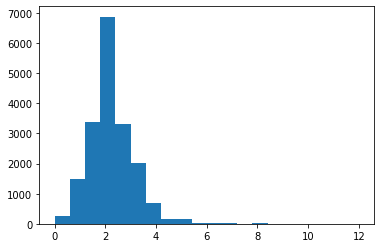

In [51]:
plt.hist(df_merged.HHVEHCNT_mean, bins = 20)
# Note: well, well...The result is not as continuous as I thought.

## Normalize continuous variables

In [52]:
num_variables = ["R_AGE_IMP", "DRVRCNT", "HHSIZE", "HHFAMINC", "HHVEHCNT", "TRPMILES", "TRVLCMIN", 
                 "HBHTNRNT", "HBPPOPDN", "HBRESDN", "HHVEHCNT_P_CAP", 
                 "R_AGE_IMP_mean", "DRVRCNT_mean", "HHSIZE_mean", "HHFAMINC_mean", "HHVEHCNT_mean", "TRPMILES_mean", "TRVLCMIN_mean", 
                 "HBHTNRNT_mean", "HBPPOPDN_mean", "HBRESDN_mean", "HHVEHCNT_P_CAP_mean", 
                 "TRPTRANS_0_mean", "TRPTRANS_1_mean", "TRPTRANS_2_mean", "TRPTRANS_3_mean", 
                 "TRIPPURP_0_mean", "TRIPPURP_1_mean", "TRIPPURP_2_mean", "TRIPPURP_3_mean", "TRIPPURP_4_mean"
                ]

num_variables_norm = [num_variable+'_norm' for num_variable in num_variables]

In [53]:
### normalization for continous variables.
# It is improvable. Tried Min Max scaler. We should try more. 

from sklearn.preprocessing import StandardScaler

for idx in range(len(num_variables)):
    num_variable = num_variables[idx]
    scaler = StandardScaler()
    # 100K
    single_normalized = scaler.fit_transform(df_merged.loc[:,num_variable].values.reshape(-1,1).astype(np.float32))
    # attach new var
    num_variable_norm = num_variables_norm[idx]
    df_merged[num_variable_norm] = single_normalized


In [54]:
for c in df_merged.columns:
    print(c)

R_AGE_IMP
DRVRCNT
HHSIZE
HHFAMINC
HBHTNRNT
HBPPOPDN
HBRESDN
TRPMILES
TRVLCMIN
HHVEHCNT_P_CAP
TRPTRANS_0
TRPTRANS_1
TRPTRANS_2
TRPTRANS_3
TRIPPURP_0
TRIPPURP_1
TRIPPURP_2
TRIPPURP_3
TRIPPURP_4
HHVEHCNT
R_SEX_IMP_1
R_SEX_IMP_2
EDUC_1
EDUC_2
HH_RACE_1
HH_RACE_2
HOMEOWN_0
HOMEOWN_1
HOMEOWN_2
HBHUR_C
HBHUR_R
HBHUR_S
HBHUR_T
HBHUR_U
R_AGE_IMP_mean
DRVRCNT_mean
HHSIZE_mean
HHFAMINC_mean
HBHTNRNT_mean
HBPPOPDN_mean
HBRESDN_mean
TRPMILES_mean
TRVLCMIN_mean
HHVEHCNT_P_CAP_mean
TRPTRANS_0_mean
TRPTRANS_1_mean
TRPTRANS_2_mean
TRPTRANS_3_mean
TRIPPURP_0_mean
TRIPPURP_1_mean
TRIPPURP_2_mean
TRIPPURP_3_mean
TRIPPURP_4_mean
HHVEHCNT_mean
R_SEX_IMP_1_mean
R_SEX_IMP_2_mean
EDUC_1_mean
EDUC_2_mean
HH_RACE_1_mean
HH_RACE_2_mean
HOMEOWN_0_mean
HOMEOWN_1_mean
HOMEOWN_2_mean
HBHUR_C_mean
HBHUR_R_mean
HBHUR_S_mean
HBHUR_T_mean
HBHUR_U_mean
R_AGE_IMP_norm
DRVRCNT_norm
HHSIZE_norm
HHFAMINC_norm
HHVEHCNT_norm
TRPMILES_norm
TRVLCMIN_norm
HBHTNRNT_norm
HBPPOPDN_norm
HBRESDN_norm
HHVEHCNT_P_CAP_norm
R_AGE_IMP_mean_

## Read image data

In [55]:
# create a list of census_tract_id that exist in NHTS 
# but make them follow the same format as the raw image folder (10 digits and 11 digits)
folder_new_id_list = list(df_merged.index)
folder_old_id_list = []
for id_ in folder_new_id_list:
    if id_[0] == '0':
        folder_old_id_list.append(id_[1:])
    else:
        folder_old_id_list.append(id_) # match up to the folder names...

In [56]:
print(len(folder_old_id_list))
print(folder_old_id_list[:10])

18491
['1001020802', '1003010300', '1003010703', '1003011202', '1003011401', '1003011502', '1003011602', '1015001700', '1031011202', '1043965500']


In [57]:
# the satellite images with RPG
rgb_path_name = "data_initial/satellite/img"
dir_names_ = os.listdir(rgb_path_name)
d10,d11 = util.digit_counts(dir_names_,SAT=True)
print(d10,d11)
print(dir_names_[:10])

7989 27234
['wms6037127803.jpg', 'wms48201220500.jpg', 'wms6037183610.jpg', 'wms12086013200.jpg', 'wms35049001301.jpg', 'wms6089012500.jpg', 'wms12086008902.jpg', 'wms50007001100.jpg', 'wms48029181822.jpg', 'wms33011025500.jpg']


In [58]:
# initialize black and white images
file_size = (224, 224) # default sizes in all CNN architectures
image_array = np.zeros((len(folder_old_id_list), num_channels, file_size[0], file_size[1])) # default: black images

In [59]:
sys.getsizeof(image_array) # 29GB. 

29689741456

In [57]:
# read the images. 
empty = 0
non_empty = 0

for folder_name_idx in np.arange(len(folder_old_id_list)):
    if folder_name_idx%500==0:
        print(folder_name_idx)
    for file_name_idx in np.arange(len(standard_file_name_list)):
        full_file_name = root_name+'/'+folder_old_id_list[folder_name_idx]+'/'+standard_file_name_list[file_name_idx]
        img = cv2.imread(full_file_name, cv2.IMREAD_UNCHANGED)
        if img is None:
            empty += 1
            pass # default is black images...so when images do not exist. Keep the zeros
        else:
            non_empty += 1
            image_array[folder_name_idx, file_name_idx, :, :] = cv2.resize(img, file_size).astype(np.uint8)

### 
print("Black and white image (empty): ", empty)
print("Black and white image (non_empty): ", non_empty)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
Black and white image (empty):  8402
Black and white image (non_empty):  65562


In [60]:
# initialize the RGB images
file_size = (224, 224) 
rgb_image_array = np.zeros((len(folder_old_id_list), 3, file_size[0], file_size[1])) 


In [59]:
# read the images.
empty = 0
non_empty = 0

for folder_name_idx in np.arange(len(folder_old_id_list)):
    if folder_name_idx%500==0:
        print(folder_name_idx)
    full_file_name = rgb_path_name+'/wms'+folder_old_id_list[folder_name_idx]+'.jpg'
    img = cv2.imread(full_file_name, cv2.IMREAD_UNCHANGED)
    if img is None:
        empty += 1
        pass # default is black images...so when images do not exist. Keep the zeros
    else:
        non_empty += 1
        rgb_image_array[folder_name_idx, :, :, :] = np.moveaxis(cv2.resize(img, file_size), 2, 0).astype(np.uint8)

### 
print("RGB images (empty): ", empty)
print("RGB images (non_empty): ", non_empty)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
RGB images (empty):  0
RGB images (non_empty):  18491


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


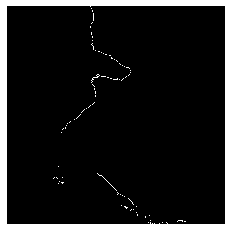

In [63]:
# plt.figure(figsize = (4,4))
util.imshow(image_array[100, 1, :, :][:,:,np.newaxis].astype('float32'))

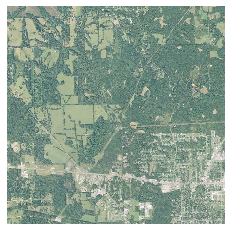

In [64]:
util.imshow(np.moveaxis(rgb_image_array[10,:,:,:], 0, 2).astype("uint8"))

In [61]:
print("NHTS and Image data match: ", df_intersect.shape[0] == image_array.shape[0])
print(image_array.shape)


NHTS and Image data match:  False
(18491, 4, 224, 224)


## Create BE variables: 3Ds
Create 3Ds from the images

In [66]:
# Design. use road network average for design
design = np.mean(image_array[:, 0, :, :] + image_array[:, 1, :, :], axis = (1,2))
print(design.shape)

(18491,)


In [67]:
# Density. use building layers' average for density
density = np.mean(image_array[:, 2, :, :] + image_array[:, 3, :, :], axis = (1,2))
print(density.shape)

(18491,)


In [68]:
# Diversity. use the entropy formula to compute diversity. 
building_density_1 = np.mean(image_array[:, 2, :, :], axis=(1,2))[:, np.newaxis]
building_density_2 = np.mean(image_array[:, 3, :, :], axis=(1,2))[:, np.newaxis]
building_densities = np.concatenate([building_density_1, building_density_2], axis = 1)

from scipy.stats import entropy
diversity = []
for i in range(building_densities.shape[0]):
    if building_densities[i, 0]*building_densities[i, 1] == 0:
        diversity_i = 0
    else:
        diversity_i = entropy(building_densities[i,:], base = 2)
    diversity.append(diversity_i)

diversity = np.array(diversity)
print(diversity.shape)

(18491,)


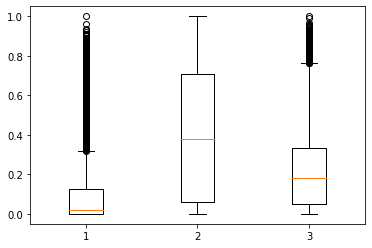

In [75]:
# create BE matrix
BE = np.vstack([density, diversity, design]).T

# 0-1 normalize
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
BE = scaler.fit_transform(BE)
plt.boxplot(BE)

# dataframe
BE_df = pd.DataFrame(BE, columns = ['density', 'diversity', 'design'], index = df_merged.index)

# df_merged = pd.con
df_merged = pd.concat([df_merged, BE_df], axis = 1)

In [76]:
df_merged

,R_AGE_IMP,DRVRCNT,HHSIZE,HHFAMINC,HBHTNRNT,HBPPOPDN,HBRESDN,TRPMILES,TRVLCMIN,HHVEHCNT_P_CAP,...,TRPTRANS_2_mean_norm,TRPTRANS_3_mean_norm,TRIPPURP_0_mean_norm,TRIPPURP_1_mean_norm,TRIPPURP_2_mean_norm,TRIPPURP_3_mean_norm,TRIPPURP_4_mean_norm,density,diversity,design
CENSUS_ID,,,,,,,,,,,,,,,,,,,,,
01001020802,54,2,2,20.0,0.1,300,50,13.430,20,1.000000,...,0.675344,-0.310812,-0.993544,-1.724233,-1.047661,0.018457,3.081432,0.000000,0.000000,0.003806
01003010300,49,2,3,112.5,0.1,50,50,10.364,7,0.666667,...,0.675344,-0.310812,0.029258,1.476451,0.047744,-1.238231,-0.390720,0.000000,0.000000,0.013154
01003010703,39,2,4,112.5,0.1,300,300,6.264,12,1.000000,...,0.675344,-0.310812,0.793327,0.749023,-1.047661,0.761045,-1.147251,0.005631,0.190895,0.111964
01003011202,49,3,4,62.5,0.3,1500,1500,3.992,15,0.750000,...,-0.044711,-0.310812,0.612922,3.133949,0.116207,-1.238231,-2.372111,0.002344,0.999932,0.118858
01003011401,69,2,2,87.5,0.2,300,300,10.131,30,1.500000,...,0.675344,-0.310812,0.612922,0.704858,-0.465727,-0.138629,-0.687929,0.000001,0.000000,0.029466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037970800,32,2,2,10.0,0.4,7000,3000,2.735,10,1.000000,...,0.675344,-0.310812,-0.336167,-0.710352,-1.047661,1.056590,0.849803,0.000001,0.000000,0.001621
56037970901,69,2,2,137.5,0.1,750,300,4.993,10,1.000000,...,0.675344,-0.310812,0.980414,1.442582,-0.357962,-0.912423,-1.124569,0.000000,0.000000,0.007002
56037970903,23,1,2,62.5,0.4,300,300,30.832,45,3.000000,...,-0.147576,-0.310812,-0.237560,1.051871,-1.047661,0.646801,-0.447331,0.014091,0.879256,0.094508


## Save Data Sets

In [135]:
# save the image arrays 1
np.save("data_process/image_array_bw_tract_large", image_array)

In [136]:
# 2
np.save("data_process/image_array_rgb_tract_large", rgb_image_array)

In [77]:
# save the full dataframe.
df_merged.to_csv("data_process/df_merged_tract_large.csv")